# Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings("ignore")

# Data

In [3]:
train = pd.read_csv('../Data/Kannada-MNIST/train.csv')
test = pd.read_csv('../Data/Kannada-MNIST/test.csv')

In [4]:
X_train = train.iloc[:, 1:].values
y_train = train.iloc[:, 0].values
X_test = test.iloc[:, 1:].values
y_test = test.iloc[:, 0].values

del train, test

In [5]:
print('Training Set')
print(len(X_train))
print(X_train.shape)
print(y_train.shape)

Training Set
60000
(60000, 784)
(60000,)


In [6]:
print('Testing Set')
print(len(X_test))
print(X_test.shape)
print(y_test.shape)

Testing Set
10240
(10240, 784)
(10240,)


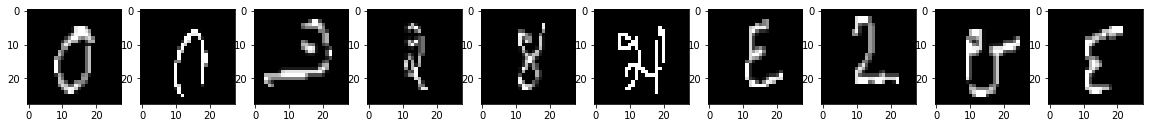

In [7]:
fig, ax = plt.subplots(1, 10, figsize=(20, 6))
for i in range(10):
    ax[i].imshow(X_train[y_train == i][0].reshape(28, 28),cmap=plt.get_cmap('gray'))

In [8]:
X_train = 255 - X_train
X_test = 255 - X_test

In [9]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255.0
X_test /= 255.0

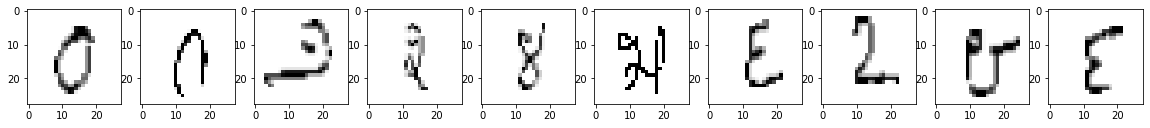

In [10]:
fig, ax = plt.subplots(1, 10, figsize=(20, 6))
for i in range(10):
    ax[i].imshow(X_train[y_train == i][0].reshape(28, 28),cmap=plt.get_cmap('gray'))

# Preparation

In [11]:
X_all = np.concatenate((X_train, X_test))
y_all = np.concatenate((y_train,  y_test))

del X_train, X_test, y_train, y_test

In [12]:
X_all = X_all.reshape(-1, 28, 28, 1)
y_all = pd.get_dummies(y_all).values

print(X_all.shape)
print(y_all.shape)

(70240, 28, 28, 1)
(70240, 10)


# Model Fitting

In [13]:
from sklearn.metrics import confusion_matrix, classification_report

In [14]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, Flatten, MaxPooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


## Convolutional Neural Network

In [15]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
filepath = "lens-kdigi.h5"
ckpt = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
rlp = ReduceLROnPlateau(patience=2)

def cnn(image_size):
    classifier = Sequential()
    classifier.add(Conv2D(32, (5, 5), input_shape = (*image_size, 1), activation = 'relu', padding='same'))
    classifier.add(Conv2D(32, (5, 5), activation = 'relu', padding='same'))
    classifier.add(MaxPooling2D(pool_size=(2, 2)))
    classifier.add(Dropout(0.25))
    classifier.add(Conv2D(64, (3, 3), activation = 'relu', padding='same'))
    classifier.add(Conv2D(64, (3, 3), activation = 'relu', padding='same'))
    classifier.add(MaxPooling2D(pool_size=(2, 2)))
    classifier.add(Dropout(0.25))
    classifier.add(Flatten())
    classifier.add(Dense(units = 10, activation = 'softmax'))
    classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
    classifier.summary()
    return classifier


model = cnn((28,28))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        832       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        25632     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 64)         

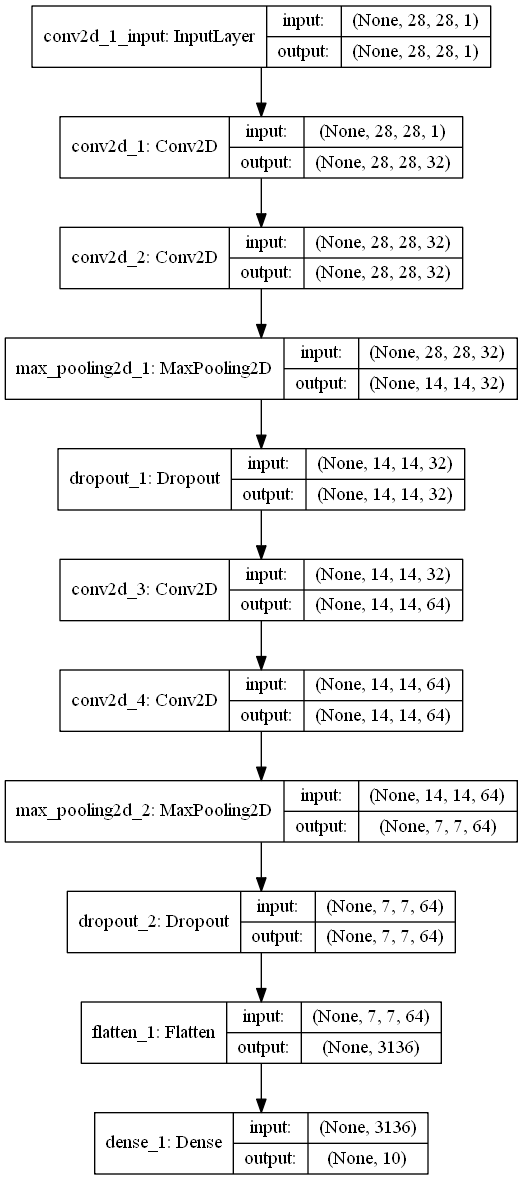

In [16]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [17]:
datagen = ImageDataGenerator(
    rotation_range=10, 
    zoom_range = 0.1,
    width_shift_range=0.1, 
    height_shift_range=0.1,
    validation_split=0.1
)  

datagen.fit(X_all)

training_set = datagen.flow(
    x=X_all, y=y_all,
    subset='training'
)

validation_set = datagen.flow(
    x=X_all, y=y_all,
    subset='validation'
)

In [18]:
history = model.fit_generator(training_set, validation_data=validation_set, epochs=1000, callbacks=[es, ckpt, rlp])

Epoch 1/1000
1976/1976 [==============================] - 371s 188ms/step - loss: 0.3333 - accuracy: 0.8949 - val_loss: 0.0397 - val_accuracy: 0.9643

Epoch 00001: val_loss improved from inf to 0.03965, saving model to lens-kdigi.h5
Epoch 2/1000
1976/1976 [==============================] - 350s 177ms/step - loss: 0.1198 - accuracy: 0.9652 - val_loss: 0.0036 - val_accuracy: 0.9744

Epoch 00002: val_loss improved from 0.03965 to 0.00361, saving model to lens-kdigi.h5
Epoch 3/1000
1976/1976 [==============================] - 349s 177ms/step - loss: 0.0932 - accuracy: 0.9722 - val_loss: 0.0241 - val_accuracy: 0.9698

Epoch 00003: val_loss did not improve from 0.00361
Epoch 4/1000
1976/1976 [==============================] - 637s 323ms/step - loss: 0.0832 - accuracy: 0.9754 - val_loss: 0.0193 - val_accuracy: 0.9775

Epoch 00004: val_loss did not improve from 0.00361
Epoch 5/1000
1976/1976 [==============================] - 669s 339ms/step - loss: 0.0549 - accuracy: 0.9830 - val_loss: 0.0818

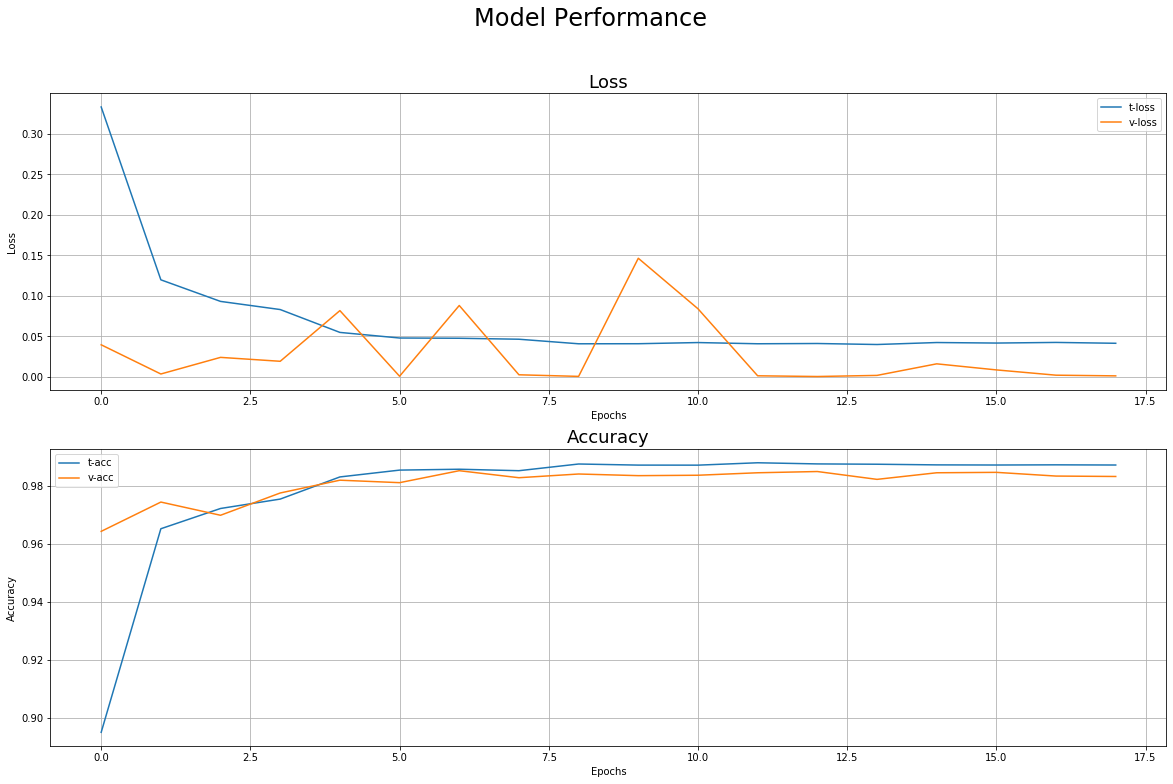

In [19]:
fig, ax = plt.subplots(2, 1, figsize=(20, 12))

fig.suptitle('Model Performance', fontsize=24) 

ax[0].plot(history.history['loss'], label='t-loss')
ax[0].plot(history.history['val_loss'], label='v-loss')
ax[0].set_title('Loss', fontsize=18)
ax[0].set_ylabel('Loss')

ax[1].plot(history.history['accuracy'], label='t-acc')
ax[1].plot(history.history['val_accuracy'], label='v-acc')
ax[1].set_title('Accuracy', fontsize=18)
ax[1].set_ylabel('Accuracy')


for i in range(2):
    ax[i].grid()
    ax[i].legend()
    ax[i].set_xlabel('Epochs')
    
plt.savefig('history.png')    